# Automatic Speech Recognition

In [ ]:
%pip install -r requirements.txt

In [ ]:
import os
import pathlib
import random
import warnings
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from hmmlearn.hmm import GMMHMM
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.utils.data as tud
import pandas as pd
import seaborn as sns
import sounddevice as sd
from scipy.io.wavfile import write
import time
from tqdm.auto import tqdm
from dtaidistance import dtw

warnings.filterwarnings('ignore')

c:\Users\zolta\Desktop\MATHOS\AutomaticSpeechRecognition\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.  Get the dataset

In [3]:
DATA_DIR = pathlib.Path('fsdd').resolve()

if not DATA_DIR.exists():
    print('Downloading FSDD...')
    !git clone --depth 1 https://github.com/Jakobovski/free-spoken-digit-dataset.git fsdd
else:
    print('FSDD already downloaded at', DATA_DIR)

FSDD already downloaded at C:\Users\zolta\Desktop\MATHOS\AutomaticSpeechRecognition\fsdd


In [4]:
# Checking out one sample

sample_path = random.choice(glob.glob(str(DATA_DIR / 'recordings' / '*.wav')))
print('Sample file:', os.path.basename(sample_path))
audio, sr = librosa.load(sample_path, sr=8000)
ipd.Audio(audio, rate=sr)

Sample file: 1_lucas_48.wav


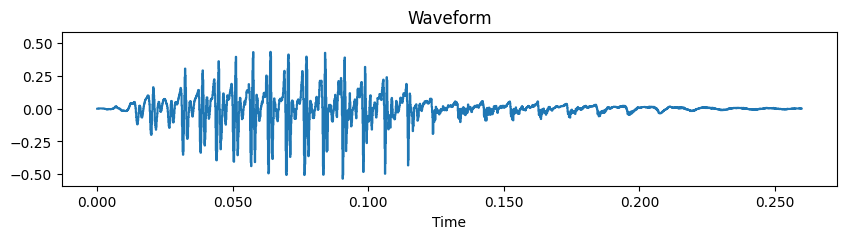

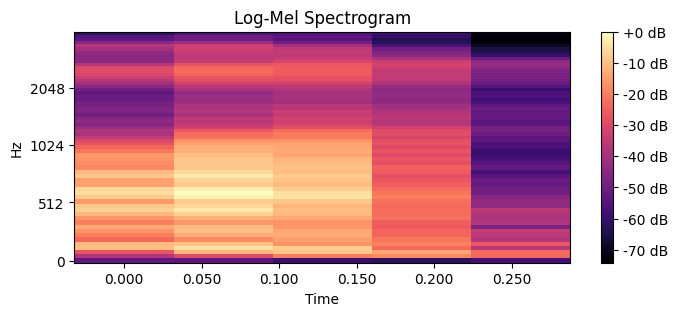

In [5]:
# Display waveform 
plt.figure(figsize=(10,2))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform')
plt.show()

# Display the Log-Mel spectrogram
S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=64, fmax=4000)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(8,3))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.show()

## 2.  Feature extraction

In [6]:
def extract_mfcc(path, sr=8000, n_mfcc=13):
    y, _ = librosa.load(path, sr=sr)
    mfcc_feat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=256, n_fft=512)

    if mfcc_feat.shape[1] < 5:
        # Not enough frames for delta computation
        delta_feat = np.zeros_like(mfcc_feat)
    else:
        delta_feat = librosa.feature.delta(mfcc_feat, width=5)

    return np.vstack([mfcc_feat, delta_feat]).T  # shape (T, 26)

def extract_logmel(path, sr=8000, n_mels=64, max_frames=128):
    y, _ = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=4000)
    logmel = librosa.power_to_db(mel, ref=np.max)
    # Pad / truncate to fixed length for CNN
    if logmel.shape[1] < max_frames:
        pad = np.full((n_mels, max_frames-logmel.shape[1]), logmel.min())
        logmel = np.hstack([logmel, pad])
    else:
        logmel = logmel[:, :max_frames]
    return logmel  # shape (64, max_frames)

In [7]:
# Build feature lists for all recordings
file_list = sorted(pathlib.Path(DATA_DIR/'recordings').glob('*.wav'))
labels = [int(f.name.split('_')[0]) for f in file_list]

mfcc_sequences = [extract_mfcc(str(p)) for p in file_list]
logmel_images  = [extract_logmel(str(p)) for p in file_list]

print('Total samples:', len(file_list))

Total samples: 3000


In [8]:
# Split the data into train/test sets
idx = list(range(len(file_list)))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=labels)

print(f'Train: {len(train_idx)}, Test: {len(test_idx)}')

Train: 2400, Test: 600


## 3.  DTW 1‑NN baseline

In [11]:
%pip install dtaidistance

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 12.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DTW Matching: 100%|██████████| 600/600 [11:38<00:00,  1.16s/it]

DTW accuracy: 0.5966666666666667


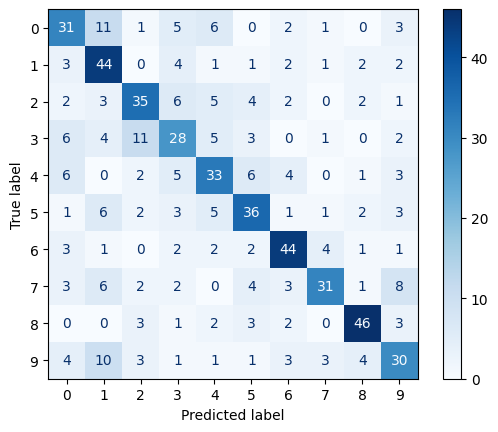

In [26]:
def dtw_distance(a, b):
    return dtw.distance(a[:, 0], b[:, 0]) 

def predict_dtw(sample_seq, ref_idx):
    distances = [dtw_distance(sample_seq, mfcc_sequences[r]) for r in ref_idx]
    best = ref_idx[int(np.argmin(distances))]
    return labels[best]

y_true = [labels[i] for i in test_idx]
y_pred = [predict_dtw(mfcc_sequences[i], train_idx) for i in tqdm(test_idx, desc="DTW Matching")]

dtw_acc = accuracy_score(y_true, y_pred)
print('DTW accuracy:', dtw_acc)

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

## 4.  GMM‑HMM per digit

Training HMMs: 100%|██████████| 10/10 [04:32<00:00, 27.29s/it]


HMM accuracy: 0.9916666666666667


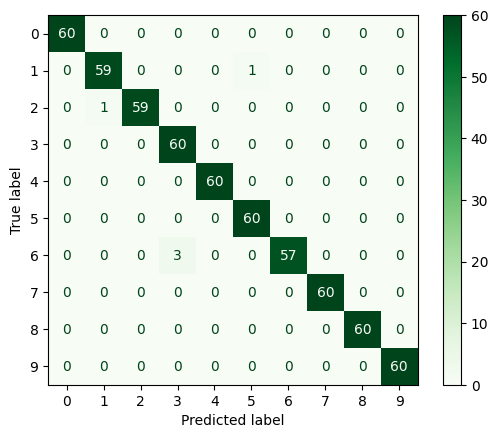

In [16]:
digit_models = {}
for d in tqdm(range(10), desc="Training HMMs"):
    seqs = [mfcc_sequences[i] for i in train_idx if labels[i] == d]
    lengths = [len(s) for s in seqs]
    X = np.vstack(seqs)
    model = GMMHMM(n_components=5, n_mix=4, covariance_type='diag', n_iter=100, verbose=False)
    model.fit(X, lengths)
    digit_models[d] = model

def predict_hmm(seq):
    scores = {d: m.score(seq) for d,m in digit_models.items()}
    return max(scores, key=scores.get)

y_pred_hmm = [predict_hmm(mfcc_sequences[i]) for i in test_idx]
hmm_acc = accuracy_score(y_true, y_pred_hmm)
print('HMM accuracy:', hmm_acc)

cm = confusion_matrix(y_true, y_pred_hmm)
ConfusionMatrixDisplay(cm).plot(cmap='Greens')

## 5.  CNN classifier

In [17]:
class CNNDigit(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


Training: 100%|██████████| 250/250 [04:13<00:00,  1.01s/it]


CNN accuracy (best model): 0.9233333333333333


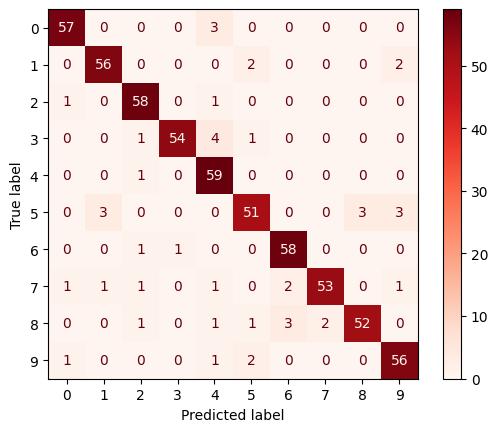

In [19]:
# Build tensors
X_images = torch.tensor(np.stack([img for img in logmel_images]), dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(labels, dtype=torch.long)

X_images = (X_images - X_images.mean()) / X_images.std()

train_ds = tud.TensorDataset(X_images[train_idx], y_tensor[train_idx])
test_ds  = tud.TensorDataset(X_images[test_idx],  y_tensor[test_idx])
train_loader = tud.DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = tud.DataLoader(test_ds,  batch_size=32)

model = CNNDigit().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)
loss_fn = nn.CrossEntropyLoss()

best_loss = float('inf')
best_model_state = None  # This will store the best model weights

EPOCHS = 250
for epoch in tqdm(range(EPOCHS), desc='Training'):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    
    # Save model with lowest loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()  # Save best model weights

    scheduler.step()

# Load best model state into a fresh model instance
best_model = CNNDigit().to(device)
best_model.load_state_dict(best_model_state)
best_model.eval()

# Evaluate
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = best_model(xb).argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_true.extend(yb.numpy())

cnn_acc = accuracy_score(all_true, all_preds)
print('CNN accuracy (best model):', cnn_acc)

cm = confusion_matrix(all_true, all_preds)
ConfusionMatrixDisplay(cm).plot(cmap='Reds')


## 6.  Accuracy comparison

DTW    0.596667
HMM    0.991667
CNN    0.923333
dtype: float64


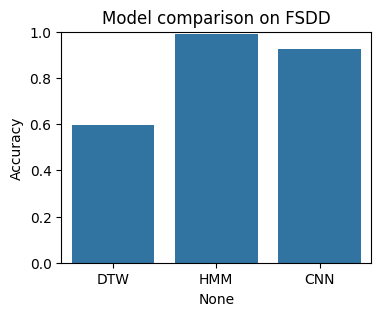

In [20]:
acc = pd.Series({'DTW': dtw_acc, 'HMM': hmm_acc, 'CNN': cnn_acc})
print(acc)

plt.figure(figsize=(4,3))
sns.barplot(x=acc.index, y=acc.values)
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Model comparison on FSDD')
plt.show()

## 7.  Record your own digit

In [42]:
fs = 8000
seconds = 1
print('>> Speak a single digit (0-9) after the beep...')
time.sleep(0.5)
sd.play(0.5*np.sin(2*np.pi*440*np.linspace(0,0.2,int(0.2*fs))), fs)
sd.wait()
recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()
custom_digit_file_name = 'my_digit.wav'
write(custom_digit_file_name, fs, recording)
print('Saved to', custom_digit_file_name)
ipd.Audio(custom_digit_file_name)

>> Speak a single digit (0-9) after the beep...
Saved to my_digit.wav


### Predict using each model

In [43]:
seq = extract_mfcc(custom_digit_file_name)
img = extract_logmel(custom_digit_file_name)
img_t = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,64,T)

print('DTW→', predict_dtw(seq, train_idx))
print('HMM→', predict_hmm(seq))
with torch.no_grad():
    p = model(img_t.to(device)).argmax(1).item()
print('CNN→', p)

DTW→ 1
HMM→ 0
CNN→ 7
